# 全国智能电表第四类故障预测
## 数据说明
* 全国智能电表第四类故障数据
* 数据属性：**省份** **供电单位** **设备规格** **供应商** **安装月份** **故障月份** **使用时长** **通讯方式**
* 分类准确度：

In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.sparse import coo_matrix, bmat
%matplotlib inline

# Data Explore

In [2]:
data = pd.read_csv('/usr/local/hadoop/src/code/dianbiao/data/all_4.csv', dtype={0:object, 'ORG':object, 'SPEC_CODE':object, 'MANUFACTURER':object,
                                                  'FAULT_MONTH':int, 'INST_MONTH':object, 'FAULT_QUARTER':object, 
                                                  'FAULT_TYPE': object,'SYNC_ORG_NO':object,'ORG_NO':object
                                              
                                                 }, encoding='utf-8')

#preview the zhejiang_4 data
data.head()

/home/hadoop/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,EQUIP_ID,FAULT_TYPE,SYNC_ORG_NO,ORG_NO,SPEC_CODE,COMM_MODE,MANUFACTURER,FAULT_DATE1,INST_DATE1,FAULT_MONTH,INST_MONTH,month,FAULT_TYPE_1
0,120000000096143.0,408,11101,1140610,106,11,48,2015-08-10 00:00:00,2012-05-24 00:00:00,8,5,39.0,4
1,8000000042733340.0,408,11101,1140610,106,12,965,2015-08-24 00:00:00,2014-03-06 00:00:00,8,3,17.0,4
2,8000000042733830.0,408,11101,1140610,106,12,965,2015-08-24 00:00:00,2014-03-06 00:00:00,8,3,17.0,4
3,8000000042733390.0,408,11101,1140610,106,12,965,2015-08-21 00:00:00,2014-03-05 00:00:00,8,3,17.0,4
4,8000000042733460.0,408,11101,1140610,106,12,965,2015-08-24 00:00:00,2014-03-07 00:00:00,8,3,17.0,4


# feature preprocessing

In [3]:
data.drop([data.columns[0]], axis=1, inplace=True)
#data.drop_duplicates(['FAULT_TYPE', 'ORG_NO', 'SPEC_CODE', 'COMM_MODE', 'MANUFACTURER', 'FAULT_MONTH',
 #                    'INST_MONTH', 'month'], inplace=True)

In [4]:
data['FAULT_TYPE'].value_counts()

409    138923
404     83185
411     83173
407     79011
408     60459
401     37631
402     29698
410     18601
405      7637
406      5895
403      5817
Name: FAULT_TYPE, dtype: int64

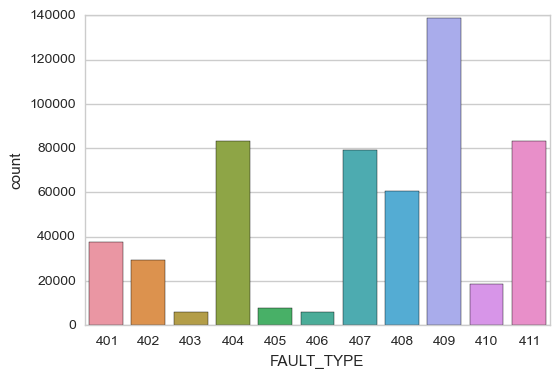

In [5]:
fig, axis0 = plt.subplots(1, 1)
sns.countplot(x='FAULT_TYPE', data=data, ax=axis0)

从故障类型柱状图可以看出故障类型数据不平衡，403,405,406,410较少，希望后续提供更多此类数据。

## SYNC_ORG_NO

count     550030
unique        15
top        33101
freq      190996
Name: SYNC_ORG_NO, dtype: object


/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


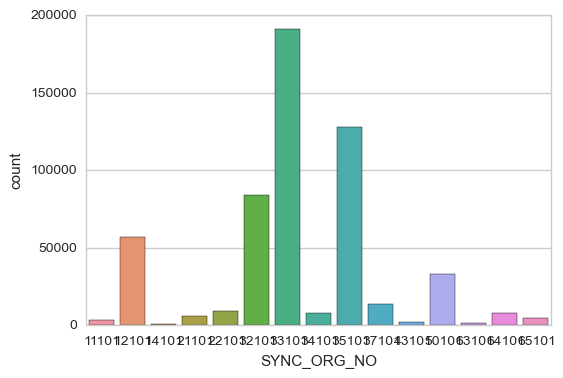

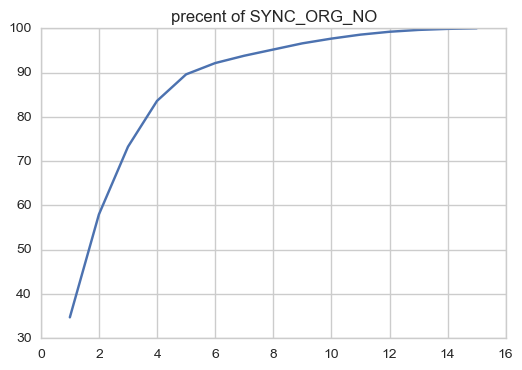

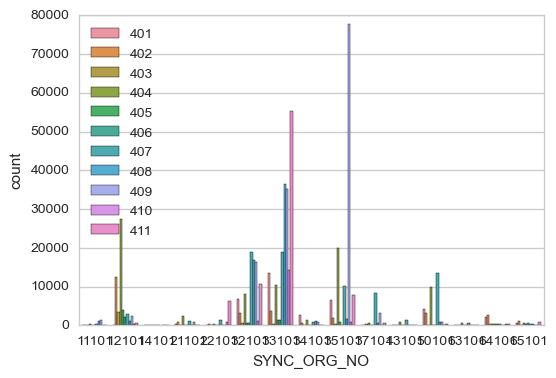

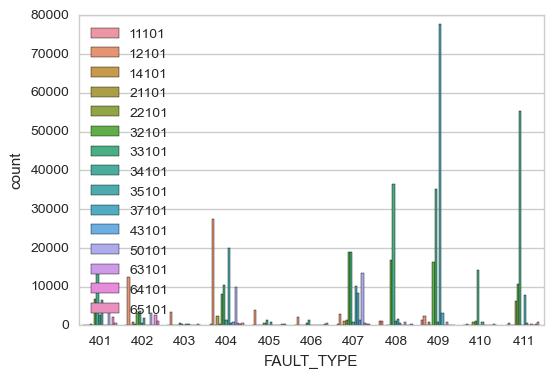

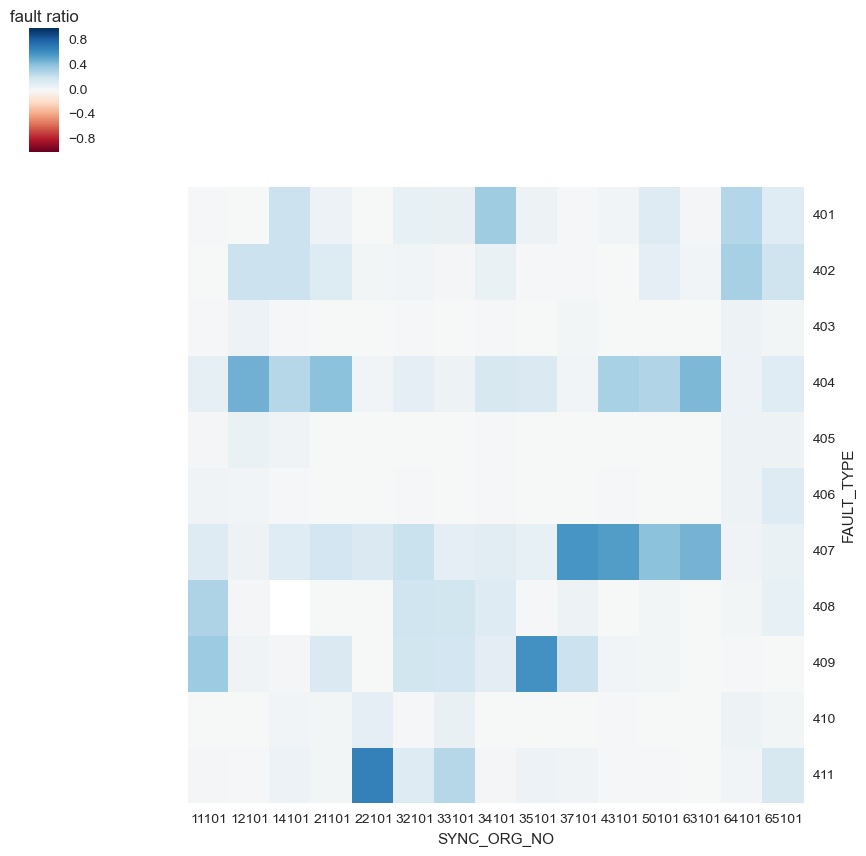

In [6]:
#ORG
print data['SYNC_ORG_NO'].describe()
#plot
def plot_fun(name_fea, name_fault, figsize=None, fontsize=None):
    
    
    plt.figure(figsize=figsize)
    fig, axis1 = plt.subplots(1, 1)
    sns.countplot(x=name_fea, data=data, ax = axis1)
    
    plt.figure(figsize=figsize)
    fig, axis2 = plt.subplots(1, 1)
    c = data[name_fea].value_counts()
    s = c.cumsum()/c.sum()
    axis2.plot(np.arange(s.shape[0])+1, s.values*100)
    axis2.set_title('precent of %s'%name_fea)
    
    plt.figure(figsize=figsize)
    fig, axis3 = plt.subplots(1, 1)
    sns.countplot(x=name_fea, hue=name_fault, data=data, ax=axis3)
    plt.legend(loc = 2)
    plt.figure(figsize=figsize)
    fig, axis4 = plt.subplots(1, 1)
    sns.countplot(x=name_fault, hue=name_fea, data=data, ax=axis4)
    plt.legend(loc = 2, fontsize=fontsize)

    #calculate similar score
    from scipy.cluster.hierarchy import dendrogram, linkage    
    #clustermap

    fault_num1 = data.groupby([name_fault, name_fea])[data.columns[0]].count().unstack()

    ratio = fault_num1 / fault_num1.sum()  

    g1 = sns.clustermap(ratio, 
                        cmap=plt.get_cmap('RdBu'),
                        vmax=1,
                        vmin=-1,
                        linewidth=0,
                        figsize=(10, 10),
                        row_cluster=False,
                        col_cluster=False
                    )
    plt.title('fault ratio')

#plot
plot_fun('SYNC_ORG_NO', 'FAULT_TYPE')
#get_dummies
SYNC_ORG_dummies = coo_matrix(pd.get_dummies(data['SYNC_ORG_NO']))

## 省份故障类型统计
* 图1为省份数量分布图，有四个省的故障数据比较集中。
* 图2为省份故障数量占比图，故障数据主要集中在前5个省，占比达90%
* 图3为省份-故障类型数量图，每个省的故障类型分布不同，初步判断为故障类型的影响变量
* 图4为故障类型-省份图，每种故障类型在每个省的分布不同
* 图5为省份-故障类型占比图，可以看出每个省份故障类型比例，可以用于相似省份聚类

count     550030
unique      2961
top        35401
freq       26187
Name: ORG_NO, dtype: object
(550030, 596)


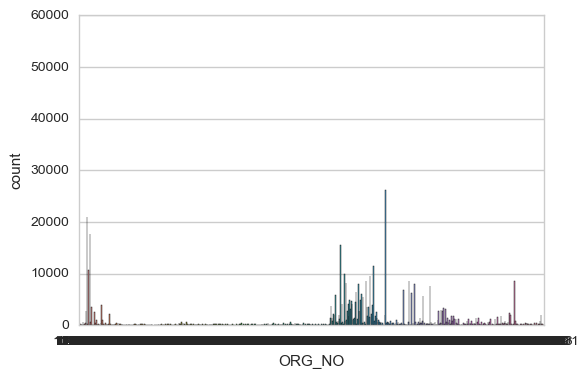

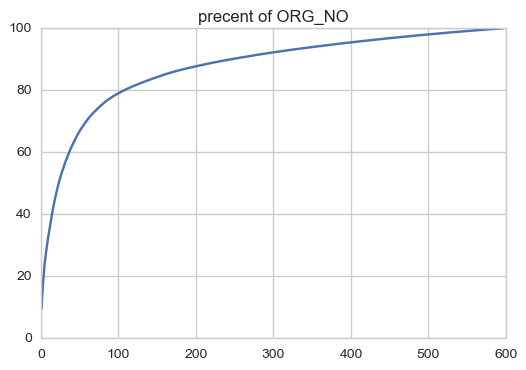

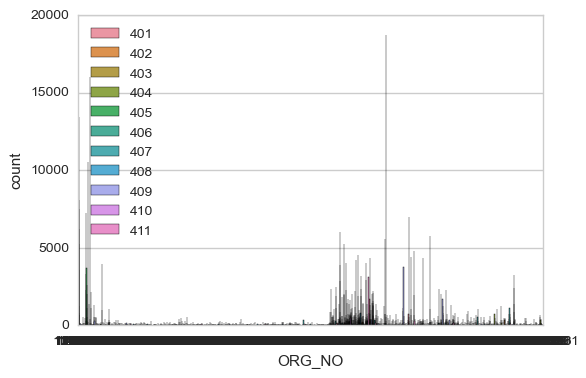

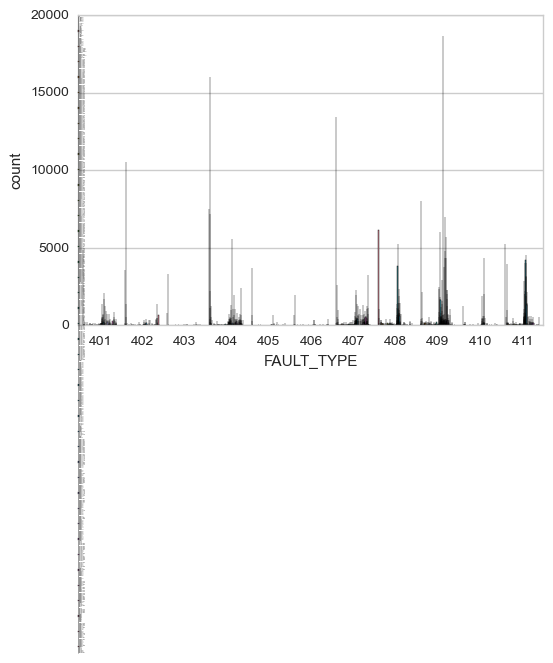

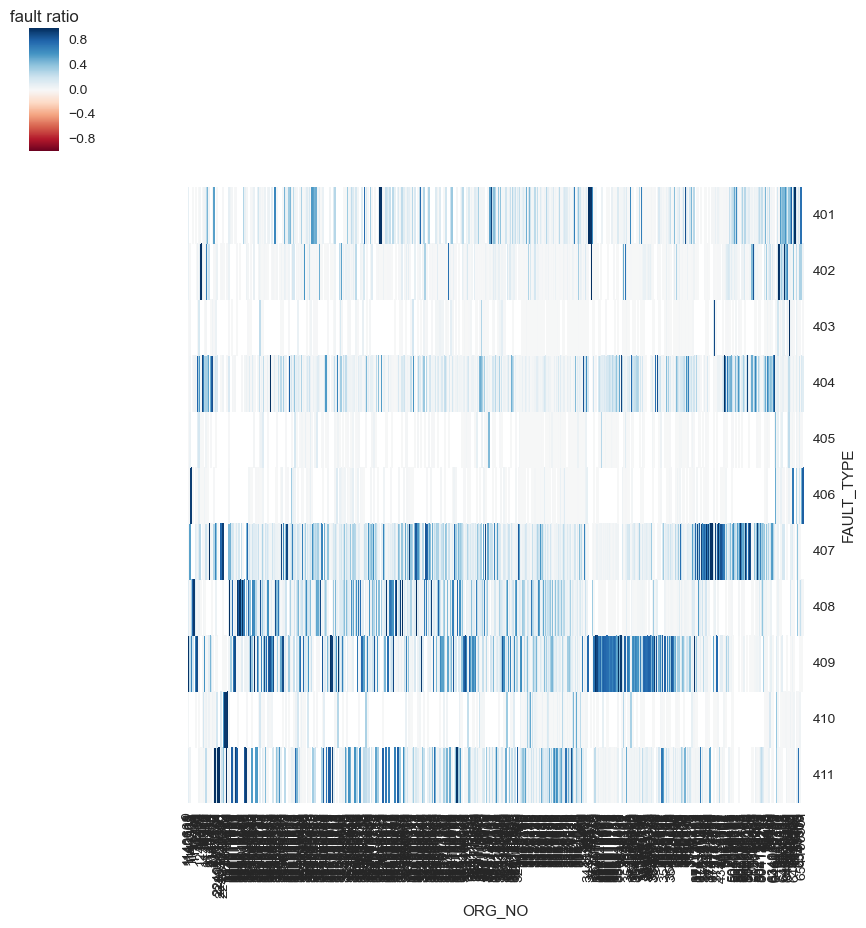

In [7]:
#ORG
print data['ORG_NO'].describe()
#plot
#get_dummies
ORG_freq = data['ORG_NO'].value_counts().index[data['ORG_NO'].value_counts().values<100]
data['ORG_NO'] = data['ORG_NO'].replace(ORG_freq.values, 0)
plot_fun('ORG_NO', 'FAULT_TYPE', figsize=(20,6),fontsize=0.1)
ORG_dummies = coo_matrix(pd.get_dummies(data['ORG_NO']))# 转化为稀疏矩阵
#ORG_dummies.drop(['33101', '33407', '33411'], axis=1, inplace=True)
print ORG_dummies.shape

## 供电单位故障类型统计
* 图1为供电单位数量分布图，分布呈现出故障在部分供电单位集中出现，均匀少量的出现在其他区域，且供电单位数量庞大。
* 图2为供电单位故障数量占比图，故障数据主要集中在100个供电单位，占比达80%
* 图3为供电单位-故障类型数量图，每个供电单位的故障类型分布不同，初步判断为故障类型的影响变量
* 图4为故障类型-供电单位图，每种故障类型在每个供电单位的分布不同
* 图5为供电单位-故障类型占比图，可以看出每个供电单位故障类型比例，可以用于相似供电单位聚类
* 对属性做了二元变换处理

## SPEC_CODE

In [8]:
#SPEC_CODE
data['SPEC_CODE'].describe()

count     550030
unique        35
top          102
freq      259992
Name: SPEC_CODE, dtype: object

In [9]:
data['SPEC_CODE'].value_counts()

102    259992
100     96813
101     68483
104     51859
118     25823
108     11281
103      6217
121      6153
112      5015
106      3497
115      3101
113      2892
131      2560
129      1631
119      1157
125       849
116       748
122       411
109       312
123       295
130       222
107       204
136       151
138        89
           75
135        58
126        51
139        31
111        26
127        13
134         8
141         7
105         3
132         2
140         1
Name: SPEC_CODE, dtype: int64

[u'138' u' ' u'135' u'126' u'139' u'111' u'127' u'134' u'141' u'105' u'132'
 u'140']


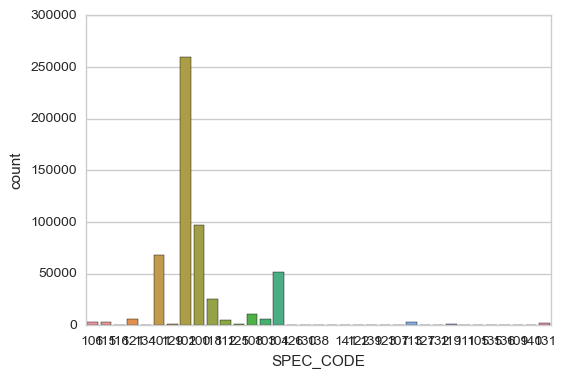

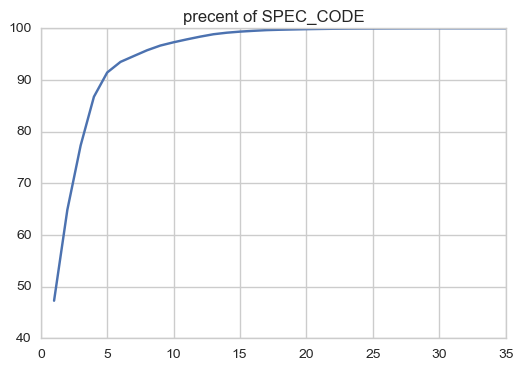

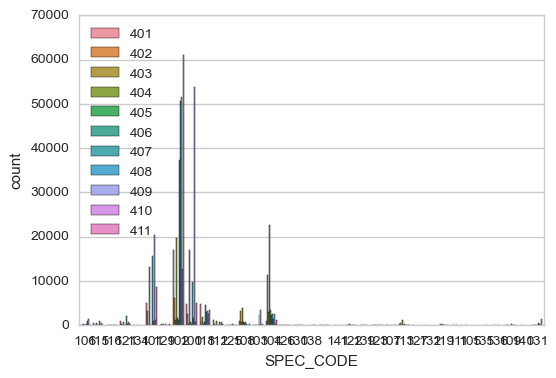

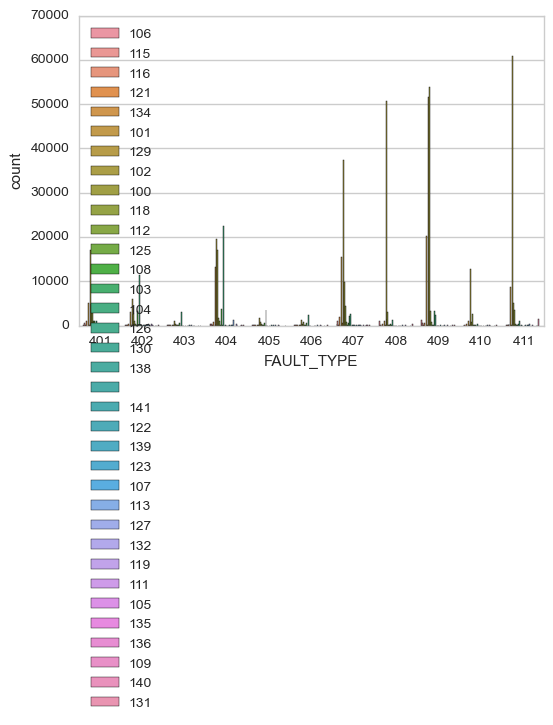

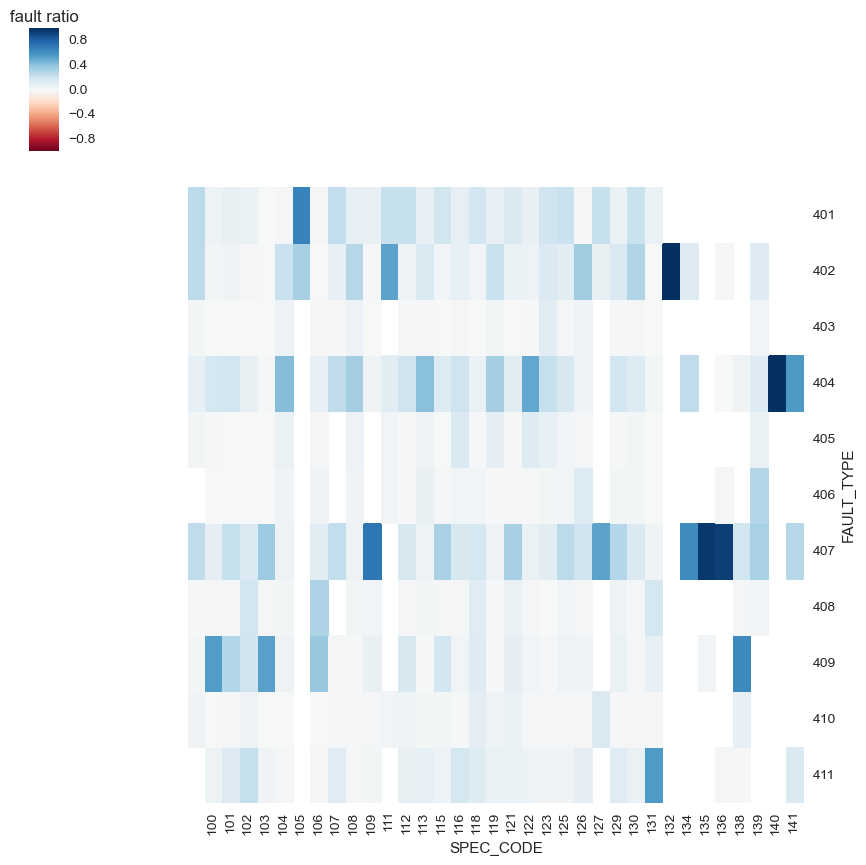

In [10]:
plot_fun('SPEC_CODE', 'FAULT_TYPE')
spec_freq = data['SPEC_CODE'].value_counts().index[data['SPEC_CODE'].value_counts().values<100]
#spec_mapping = {label:idx for label,idx in zip(spec_freq, np.zeros(len(spec_freq)))}
print spec_freq.values

In [11]:
data['SPEC_CODE'].value_counts()
data['SPEC_CODE'] = data['SPEC_CODE'].replace(spec_freq.values, 0)
print data['SPEC_CODE'].value_counts()

102    259992
100     96813
101     68483
104     51859
118     25823
108     11281
103      6217
121      6153
112      5015
106      3497
115      3101
113      2892
131      2560
129      1631
119      1157
125       849
116       748
122       411
0         364
109       312
123       295
130       222
107       204
136       151
Name: SPEC_CODE, dtype: int64


In [12]:
#get_dummies
SPEC_dummies = coo_matrix(pd.get_dummies(data['SPEC_CODE']))

## 设备规格故障类型统计
* 图1为设备规格数量分布图，分布呈现出故障在部分设备规格集中出现在5种设备规格中，102（2级单相费控智能电能表（远程-开关内置））最多，其他的占比较小。
* 图2为设备规格故障数量占比图，故障数据主要集中在5个设备规格，占比达90%以上
* 图3为设备规格-故障类型数量图，每个供电单位的故障类型分布不同，初步判断为故障类型的影响变量
* 图4为设备规格-供电单位图，每种故障类型在每个设备规格的分布不同
* 图5为设备规格-故障类型占比图，可以看出每个设备规格故障类型比例，可以用于相似设备规格聚类
* 对数量小于100的设备规格类型进行合并
* 对属性做了二元变换处理

# MANUFACTURER

In [13]:
data['MANUFACTURER'].value_counts()
print len(data['MANUFACTURER'].value_counts())

125


In [14]:
spec_freq = data['MANUFACTURER'].value_counts().index[data['MANUFACTURER'].value_counts().values<500]
data['MANUFACTURER'] = data['MANUFACTURER'].replace(spec_freq.values, 0)
print len(data['MANUFACTURER'].value_counts())

78


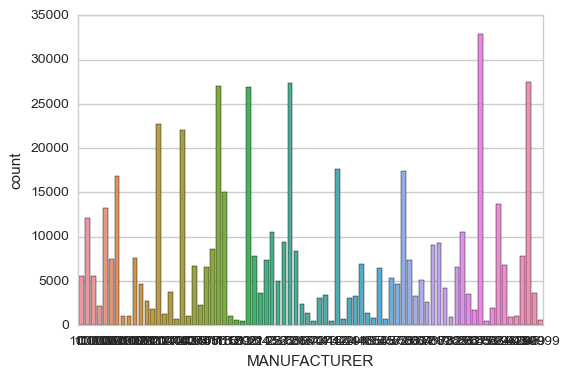

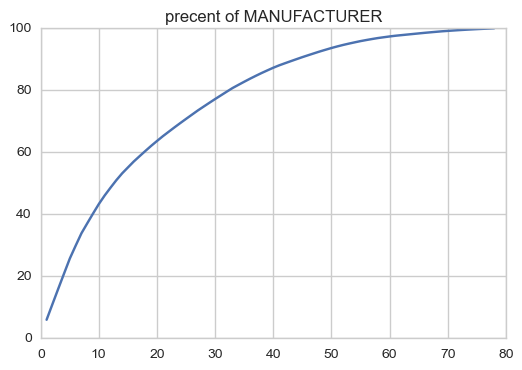

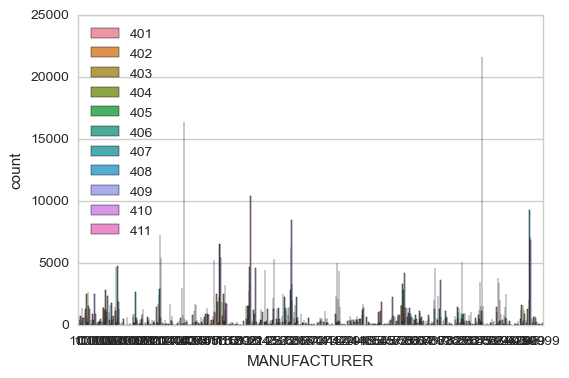

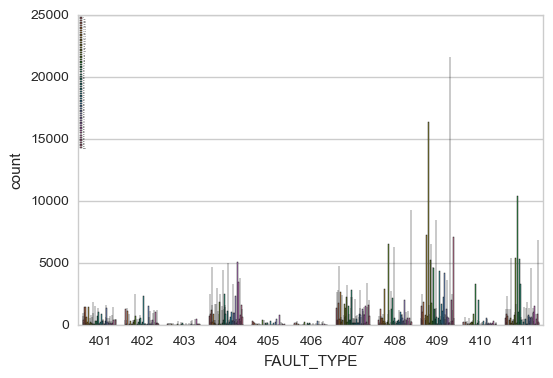

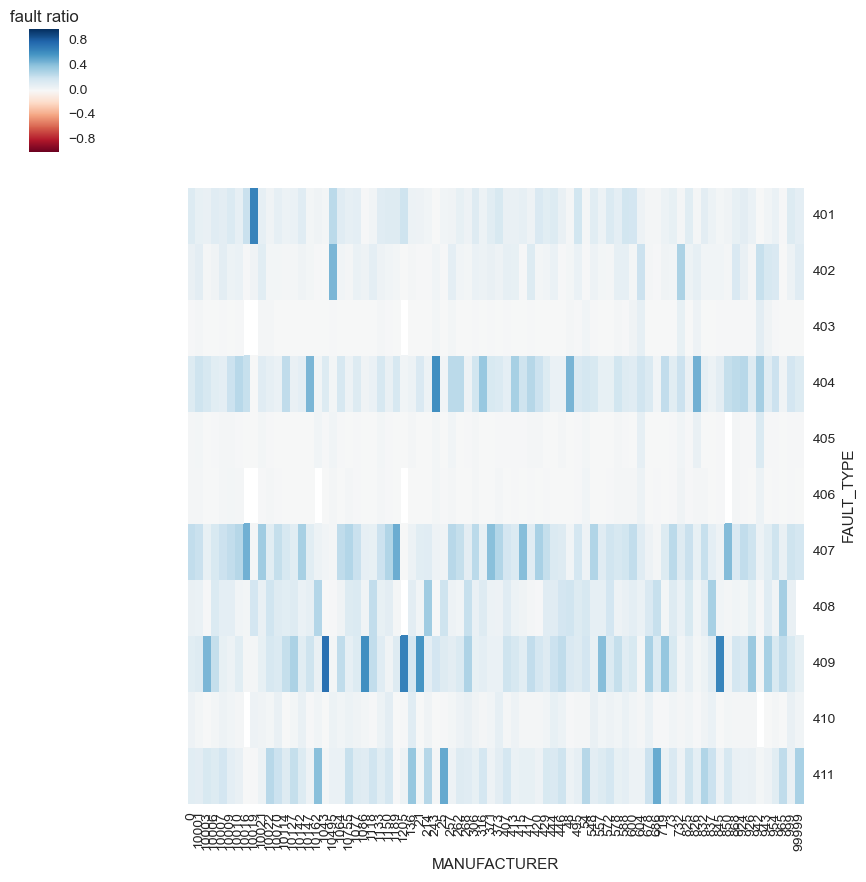

In [15]:
#plot
plot_fun('MANUFACTURER', 'FAULT_TYPE',figsize=(20,6), fontsize=1)
'''
#cluster encoding
from scipy.cluster.hierarchy import fclusterdata
fault_num3 = data.groupby(['FAULT_TYPE', 'MANUFACTURER'])[data.columns[0]].count().unstack()

MAN_ratio = fault_num3 / fault_num3.sum()
MAN_ratio_T = MAN_ratio.T

clusters = fclusterdata(np.array(MAN_ratio_T), 1)
clusters_mapping = {label:idx for label,idx in zip(MAN_ratio.columns, clusters)}


data['MANUFACTURER'] = data['MANUFACTURER'].map(clusters_mapping)
'''
#get_dummies
MAN_dummies = coo_matrix(pd.get_dummies(data['MANUFACTURER']))

## 设备供应商故障类型统计
* 图1为设备供应商数量分布图，设备供应商不集中，数量大于500的有78家
* 图2为设备供应商数量占比图，供应商数量分布相对比较均匀
* 图3为设备供应商-故障类型数量图，每个设备供应商的故障类型分布不同，初步判断为故障类型的影响变量
* 图4为设备供应商-供电单位图，每种故障类型在每个设备供应商的分布不同
* 图5为设备供应商-故障类型占比图，可以看出每个设备供应商故障类型比例，可以用于相似设备供应商聚类
* 对数量小于500的设备供应商类型进行合并
* 对属性做了二元变换处理

# COMM_MODE

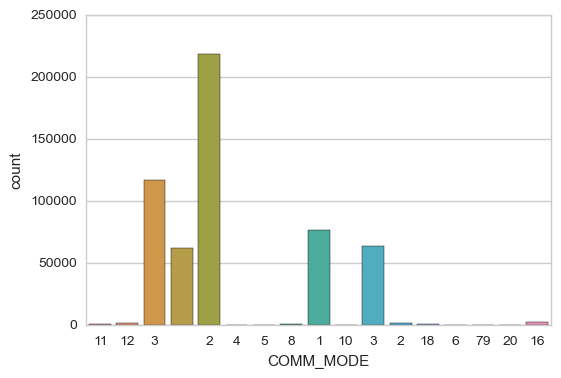

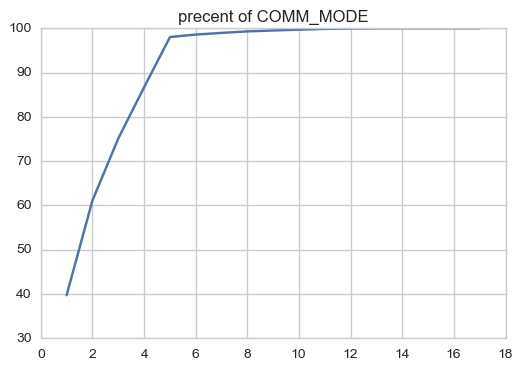

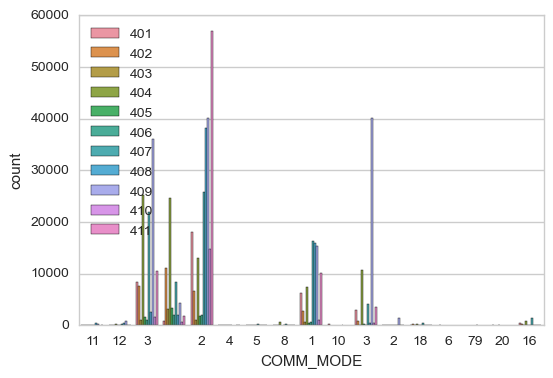

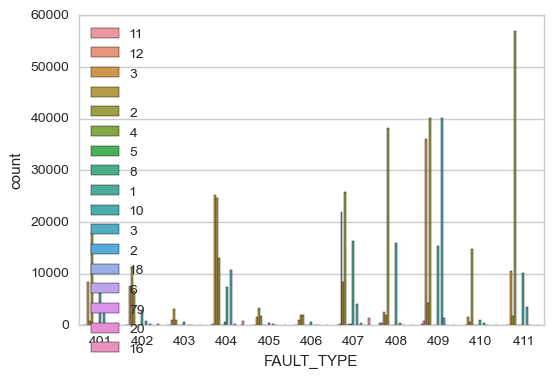

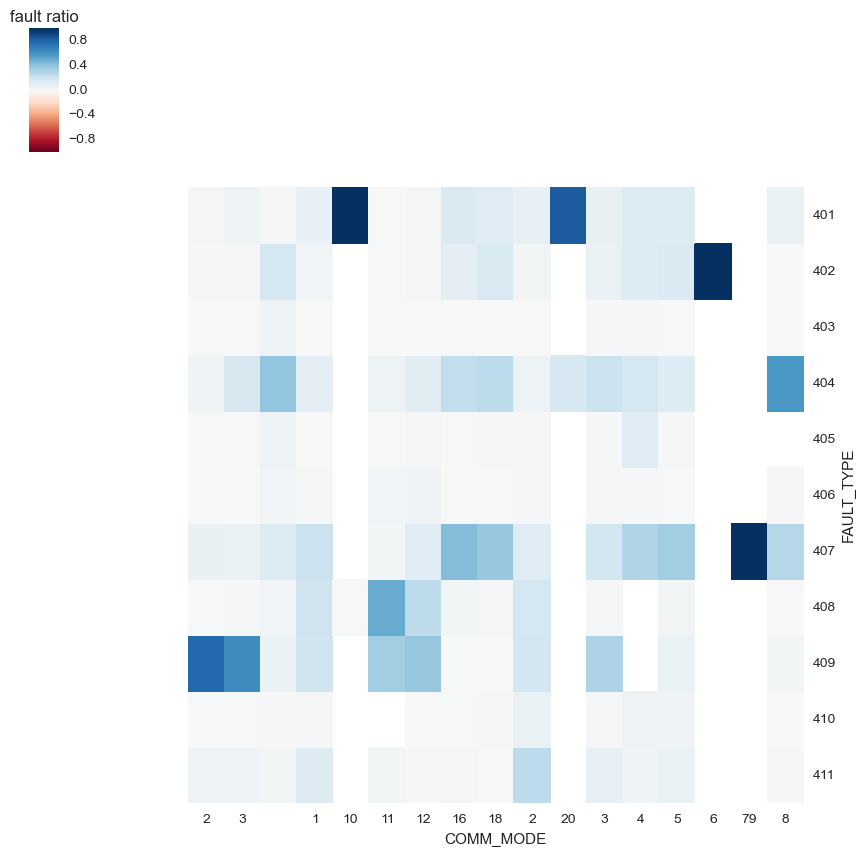

In [16]:
data['COMM_MODE'].value_counts()
plot_fun('COMM_MODE', 'FAULT_TYPE')
COMM_freq = data['COMM_MODE'].value_counts().index[data['COMM_MODE'].value_counts().values<100]
data['COMM_MODE'] = data['COMM_MODE'].replace(COMM_freq.values, 0)
COMM_dummies = coo_matrix(pd.get_dummies(data['COMM_MODE']))# 转化为稀疏矩阵

## 通讯方式-故障类型统计
* 图1为通讯方式数量分布图，主要集中于四种，且确实数据较多
* 图2为通讯方式数量占比图，通信方式数量主要集中于四种，占90%
* 图3为通讯方式-故障类型数量图，每个通讯方式的故障类型分布不同，初步判断为故障类型的影响变量
* 图4为通讯方式-供电单位图，每种故障类型在每个通讯方式的分布不同
* 图5为通讯方式-故障类型占比图，可以看出每个通讯方式故障类型比例，可以用于相似通讯方式聚类
* 对数量小于100的通讯方式类型进行合并
* 对属性做了二元变换处理

# MONTH

/home/hadoop/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/hadoop/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


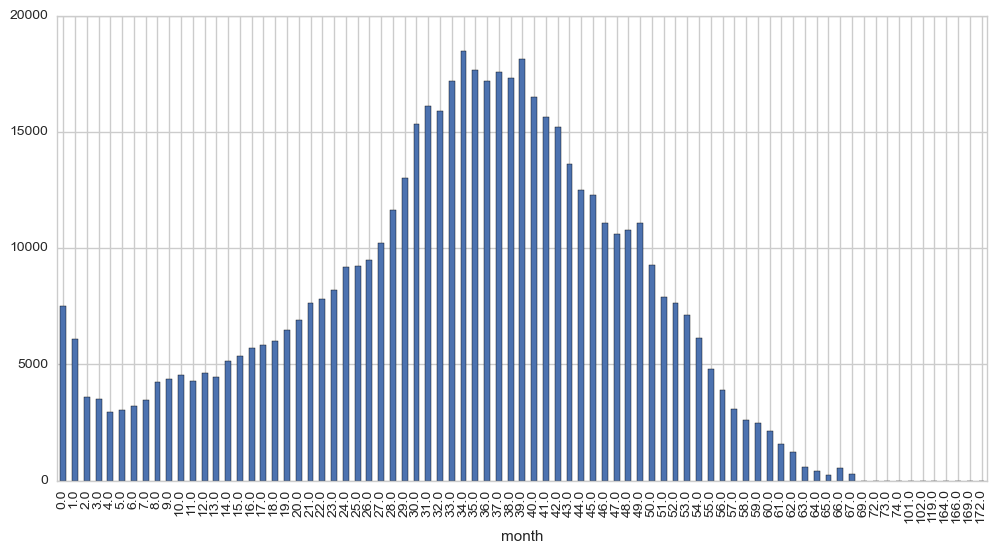

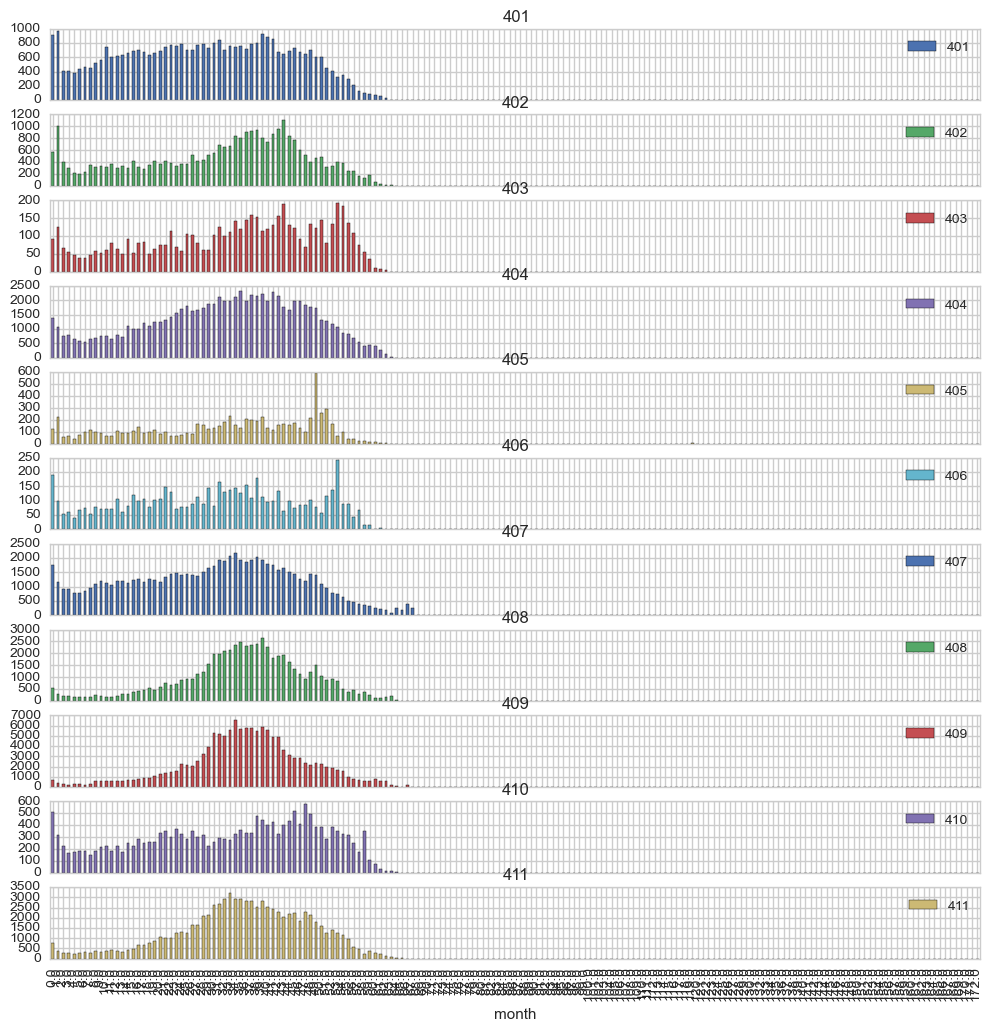

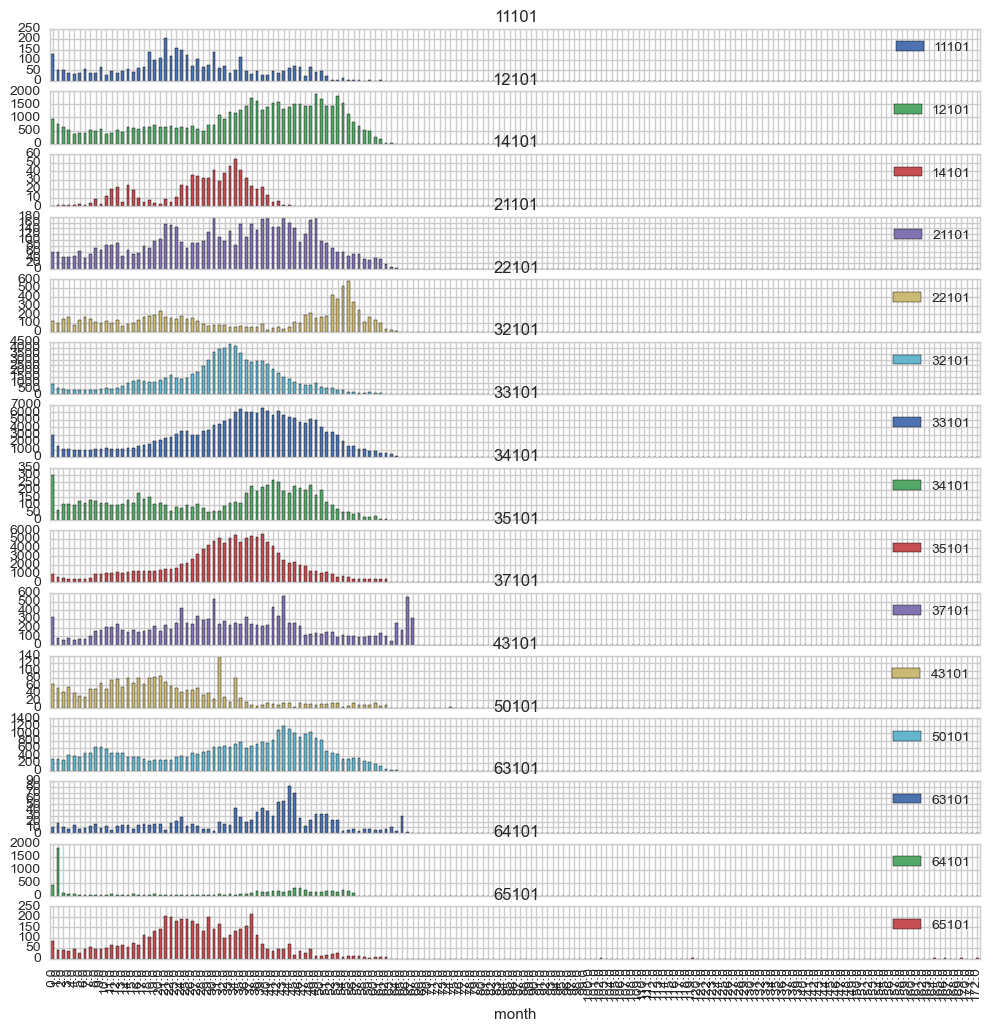

In [17]:

# use month distribution
c1 = data.groupby(['month']).size()
c1.plot(kind='bar', figsize=(12, 6))

c2 = data.groupby(['month', 'FAULT_TYPE']).size().unstack().reindex(index=np.arange(data.month.min(), data.month.max()+1)).fillna(0)
c2.plot(kind='bar', figsize=(12, 12), subplots=True)

c3 = data.groupby(['month', 'SYNC_ORG_NO']).size().unstack().reindex(index=np.arange(data.month.min(), data.month.max()+1)).fillna(0)
c3.plot(kind='bar', figsize=(12, 12), subplots=True)
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['month'] = min_max_scaler.fit_transform(data['month'])

## 使用寿命-故障类型统计
- 对全国故障电表使用寿命进行了统计，可看出其分布基本为正态分布，均值在37个月，符合客观规律。
- 使用寿命-故障类型图显示了每种故障类型的使用寿命分布情况，基本为正态分布，但是其分布参数有所不同，可以用来作为分类特征。
- 使用寿命-省份分布图，不同省份的使用寿命分布有区别，可以得出供电所对电表使用寿命有影响。

## FAULT_MONTH

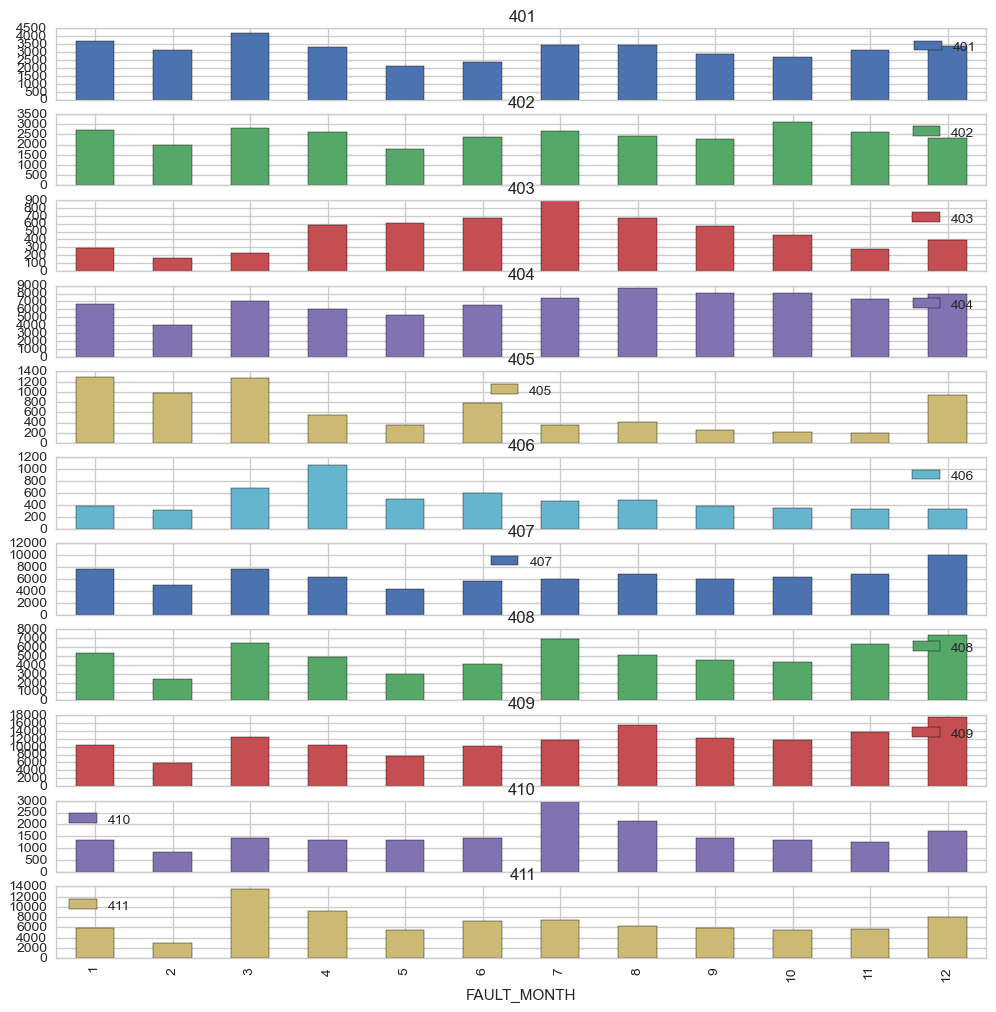

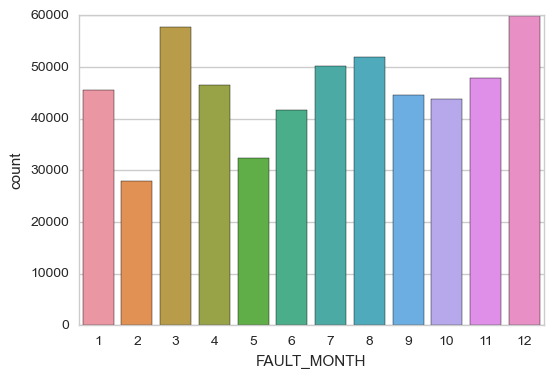

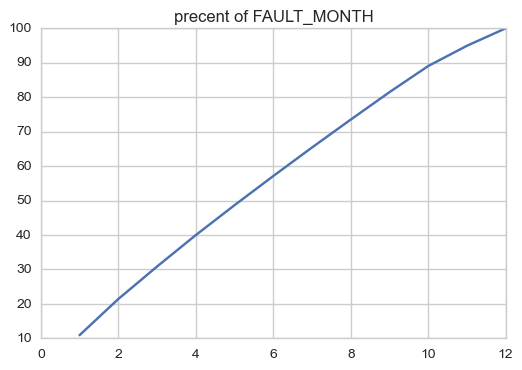

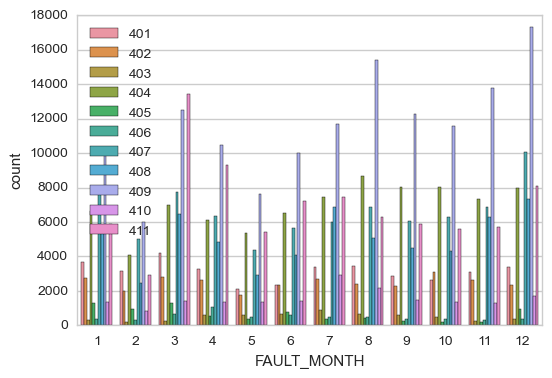

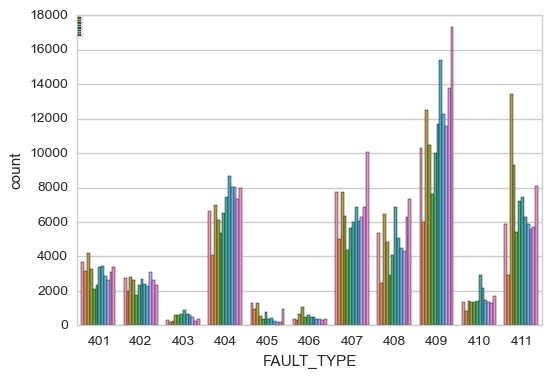

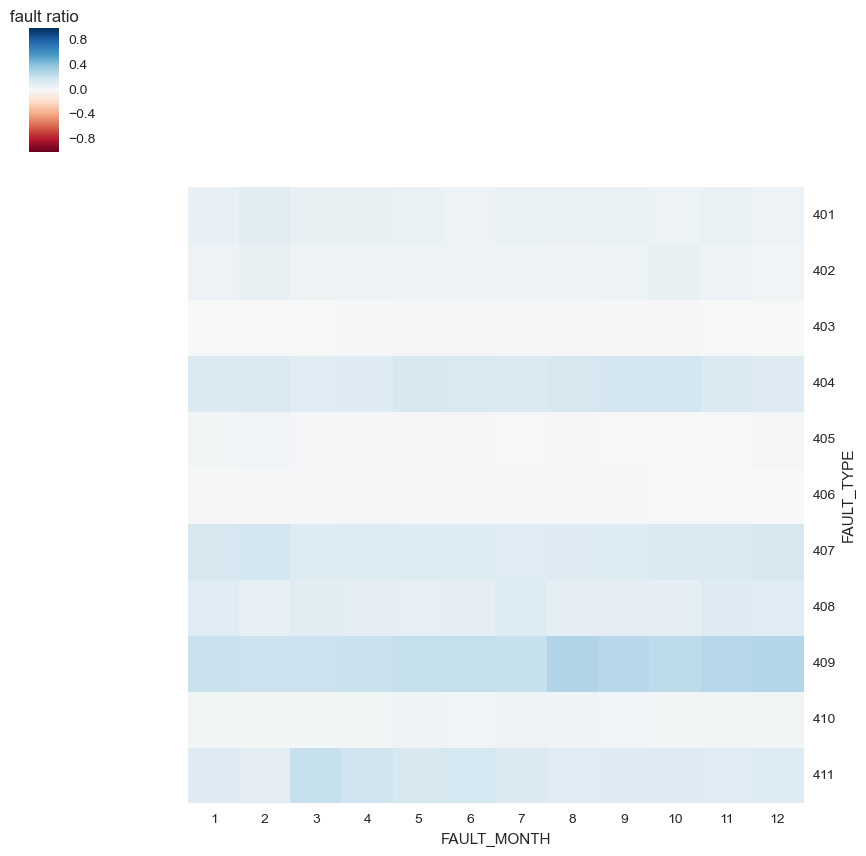

In [18]:
data['FAULT_MONTH'] = pd.Categorical(data['FAULT_MONTH'], ordered=True)

m1 = data.groupby(['FAULT_MONTH', 'FAULT_TYPE']).size().unstack().reindex(index=np.arange(data.FAULT_MONTH.min(), data.FAULT_MONTH.max()+1)).fillna(0)
m1.plot(kind='bar', figsize=(12, 12), subplots=True)
plot_fun('FAULT_MONTH', 'FAULT_TYPE', fontsize=1)
'''
fault_num4 = data.groupby(['FAULT_TYPE', 'FAULT_MONTH'])[data.columns[0]].count().unstack()

FAUMON_ratio = fault_num4 / fault_num4.sum()
FAUMON_ratio_T = FAUMON_ratio.T

clusters = fclusterdata(np.array(FAUMON_ratio_T), 0.70)
clusters = clusters+20
print clusters

clusters_mapping = {label:idx for label,idx in zip(FAUMON_ratio.columns, clusters)}


data['FAULT_MONTH'] = data['FAULT_MONTH'].map(clusters_mapping)
'''
#get_dummies
FAUMON_dummies = coo_matrix(pd.get_dummies(data['FAULT_MONTH']))

data['INST_MONTH'] = pd.Categorical(data['INST_MONTH'], ordered=True)
INSMON_dummies = coo_matrix(pd.get_dummies(data['INST_MONTH']))
#

## 故障月份-故障类型统计
- 故障月份-故障数量统计表显示了不同月份故障数量的分布，分布基本均匀
- 故障月份-故障类型图显示了每月的故障类型分布情况，每个月的故障类型占比基本相似，是比较弱的分类特征。
- 故障月份-故障类型分布图，不同月份故障类型占比基本相似。

In [19]:
data.columns

Index([u'FAULT_TYPE', u'SYNC_ORG_NO', u'ORG_NO', u'SPEC_CODE', u'COMM_MODE',
       u'MANUFACTURER', u'FAULT_DATE1', u'INST_DATE1', u'FAULT_MONTH',
       u'INST_MONTH', u'month', u'FAULT_TYPE_1'],
      dtype='object')

In [20]:
#整合数据
data = data.join(pd.DataFrame(bmat([[SYNC_ORG_dummies, ORG_dummies, SPEC_dummies, MAN_dummies, FAUMON_dummies, INSMON_dummies, COMM_dummies]]).toarray()))
data.drop(['FAULT_MONTH','SYNC_ORG_NO', 'ORG_NO', 'SPEC_CODE', 'MANUFACTURER', 'FAULT_TYPE_1', 'FAULT_DATE1', 
           'INST_DATE1', 'COMM_MODE', 'INST_MONTH'], axis=1, inplace=True)

del SYNC_ORG_dummies, ORG_dummies, SPEC_dummies, MAN_dummies, FAUMON_dummies, INSMON_dummies, COMM_dummies

## 机器学习算法故障预测

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle
from scipy.sparse import csc_matrix
data_X = data.drop(['FAULT_TYPE'], axis=1)
data_y = data['FAULT_TYPE']
#encode label
le = preprocessing.LabelEncoder()
data_y = le.fit_transform(data_y)
data_X1 = csc_matrix(data_X.ix[:200000]) 
data_X2 = csc_matrix(data_X.ix[200001:400000])
data_X3 = csc_matrix(data_X.ix[400001:])
data_X4 = bmat([[data_X1], [data_X2], [data_X3]], format='coo')
del data_X1, data_X2, data_X3
train, test, train_y, test_y = train_test_split(data_X4, data_y, test_size=0.33, random_state=27)


# XGBoost

             precision    recall  f1-score   support

        401       0.63      0.52      0.57     12447
        402       0.82      0.69      0.75      9901
        403       0.58      0.48      0.53      1899
        404       0.75      0.62      0.68     27239
        405       0.73      0.60      0.66      2509
        406       0.67      0.42      0.52      1922
        407       0.59      0.69      0.64     25894
        408       0.66      0.62      0.64     20028
        409       0.75      0.85      0.80     46013
        410       0.65      0.65      0.65      6227
        411       0.70      0.71      0.71     27431

avg / total       0.70      0.70      0.69    181510

[[ 6470   254     8   663    25    38  2347   430  1087   416   709]
 [  335  6847    22   662    15    42   918   179   390   188   303]
 [   57    65   918   325    27    51   278    30    98     9    41]
 [  690   370   182 16958   158    94  3362   760  3527   208   930]
 [   44    51    38   217  1502 

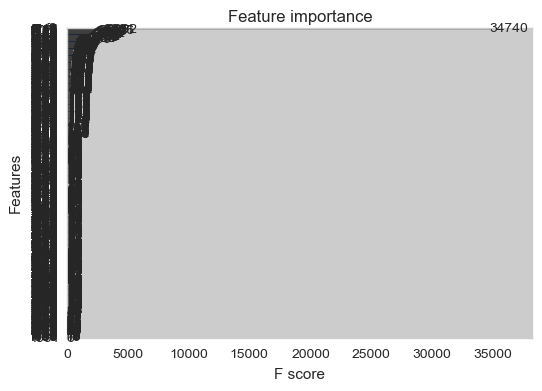

In [23]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

TRAIN = True  #是否训练
CV = False
#split train set and test set
dtrain = xgb.DMatrix(data_X4, data_y)
dtest = xgb.DMatrix(test)

clf = xgb.XGBClassifier(
    learning_rate = 0.2,
    n_estimators = 720,
    max_depth = 9,
    colsample_bytree = 0.8,
    subsample = 0.9,
    objective = 'multi:softmax',
    min_child_weight = 1,
    gamma = 2,
    seed = 27
    )

param = clf.get_xgb_params()
param['num_class'] = 11
if CV:
    cvresult = xgb.cv(param, dtrain, num_boost_round=2000, nfold=3, stratified=True,
                  metrics='merror', early_stopping_rounds=10,verbose_eval=True)
    clf.set_params(n_estimators=cvresult.shape[0])   #set n_estimators as cv rounds
if TRAIN:
    clf.fit(data_X4, data_y, eval_metric='merror')
else:
    clf = pickle.load(open("zhejiang_4_all.pkl", "rb"))
        

ypred_xgb = clf.predict(test)
ypred_xgb = le.inverse_transform(ypred_xgb)
test_y_xgb = le.inverse_transform(test_y)
#print model report:
print(classification_report(test_y_xgb, ypred_xgb))
print(confusion_matrix(test_y_xgb, ypred_xgb))

xgb.plot_importance(clf.booster())
pickle.dump(clf, open("zhejiang_4_all_jiaoliu.pkl", "wb"))


* 召回率(Recall)=  系统检索到的相关文件 / 系统所有相关的文件总数
* 准确率(Precision) =  系统检索到的相关文件 / 系统所有检索到的文件总数
* f1 = 2*Recall*Precision / (Recall+Precision)

## KNN

In [22]:
from sklearn import neighbors

USE_GridSearch = False
n_neighbors = 20
 
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
if USE_GridSearch:
    param_test1 = {'n_neighbors':range(20,60,10), 'weights':['uniform', 'distance']}
    gsearch1 = GridSearchCV(estimator=clf, param_grid = param_test1, scoring='accuracy', n_jobs=-1,cv=2, verbose=True)
    gsearch1.fit(train, train_y)
    print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
    clf = gsearch1
else:
    clf.fit(train, train_y)
ypred_knn = clf.predict(test)
ypred_knn = le.inverse_transform(ypred_knn)
test_y_knn = le.inverse_transform(test_y)
#print model report:
print(classification_report(test_y_knn, ypred_knn))
print(confusion_matrix(test_y_knn, ypred_knn))
pickle.dump(clf, open("zhejiang_4_KNN.pkl", "wb"))

MemoryError: 

* XGBoost能达到对智能电表第四类二级故障70%的分类准确率
* 对于未知数据表现较差
## 下一步计划

1. 获取能反应故障类型分布规律的数据，以提高模型的泛化能力。